In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [4]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [5]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4 TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [6]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
features_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T'])

In [7]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,17,10
CD4_T,201,95
CD8_T,23,9
DC,50,23
Mono,50,20
NK,33,17
other,4,2
other_T,247,112


## Build classifiers (K-fold CV)

In [8]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring, n_jobs=32)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [ ]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    # filename = f'LR_{celltype}_Harmony_l1.pkl'
    # with open(filename, 'wb') as f:
    #     pickle.dump(clf, f)


K-fold CV for: B
[0.9995796359814548, 0.9978968938294741, 0.9971739130434782, 0.9975351019221022, 0.9999820584799533, 0.9997959700400507, 0.997305507188958]
K-fold CV for: CD4_T
[0.9674340881649796, 0.9361588782721361, 0.9371968974634266, 0.9361425934074422, 0.9938418952850704, 0.9822994606570328, 0.9147708276262645]
K-fold CV for: CD8_T
[0.9754148169780056, 0.9444455889832206, 0.896659448741049, 0.9198154783889597, 0.9914100938572619, 0.9676618498186349, 0.9058153258416921]
K-fold CV for: DC
[0.9986090848394303, 0.9725196228393589, 0.9646142430352403, 0.9685378296145565, 0.999864684736521, 0.9942077083459511, 0.9678418739354481]
K-fold CV for: Mono
[0.9935523337039666, 0.9837476959513658, 0.99516425219343, 0.9894205992447697, 0.9987340125033976, 0.9952201121439085, 0.9848204819579175]
K-fold CV for: NK
[0.992563237332195, 0.9693488788907588, 0.9662455076805492, 0.9677534492349837, 0.9986812522716992, 0.9940306614313101, 0.9635783762837166]
K-fold CV for: other
[0.9917287073438124, 0.9

In [10]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999580,0.997897,0.997174,0.997535,0.999982,0.999796,0.997306
CD4_T,0.967434,0.936159,0.937197,0.936143,0.993842,0.982299,0.914771
CD8_T,0.975415,0.944446,0.896659,0.919815,0.991410,0.967662,0.905815
DC,0.998609,0.972520,0.964614,0.968538,0.999865,0.994208,0.967842
Mono,0.993552,0.983748,0.995164,0.989421,0.998734,0.995220,0.984820
NK,0.992563,0.969349,0.966246,0.967753,0.998681,0.994031,0.963578
other,0.991729,0.926873,0.659126,0.756311,0.930343,0.782826,0.770412
other_T,0.989689,0.907400,0.840031,0.872346,0.993196,0.931993,0.867720


In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/LR_likelihood')
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_L1_k3.csv')

## Plot classifier K-fold CV metrics

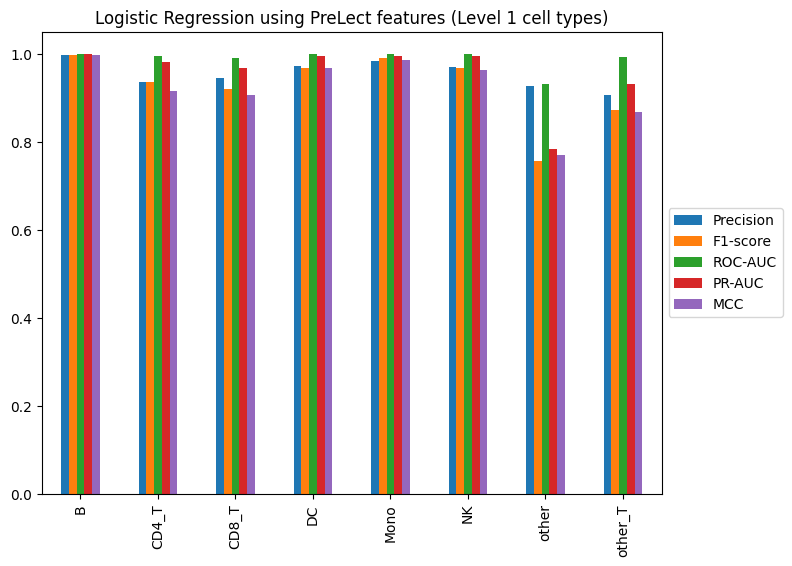

In [12]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(8,6), title='Logistic Regression using PreLect features (Level 1 cell types)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Get likelihood from LR model

In [13]:
def LR_likelihood_pred_prob(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [14]:
celltype = 'B'
B_likelihood = LR_likelihood_pred_prob(adata, features_dict, celltype)
B_likelihood.shape

Celltype: B
likelihood > 0.5: 13789


(161764,)

In [15]:
B_likelihood[:5]

array([1.51329184e-05, 2.11450618e-05, 1.87834571e-05, 3.34960626e-05,
       2.00662251e-05])

In [16]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood_pred_prob(adata, features_dict, celltype)

Celltype: B
likelihood > 0.5: 13789
Celltype: CD4_T
likelihood > 0.5: 41024
Celltype: CD8_T
likelihood > 0.5: 24135
Celltype: DC
likelihood > 0.5: 3548
Celltype: Mono
likelihood > 0.5: 49593
Celltype: NK
likelihood > 0.5: 18593
Celltype: other
likelihood > 0.5: 2441
Celltype: other_T
likelihood > 0.5: 6294


In [17]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,0.000015,0.000019,0.000110,4.338845e-05,0.967427,0.000031,0.002287,4.302029e-07
1,0.000021,0.997751,0.000674,9.925294e-09,0.000041,0.000140,0.002949,1.215517e-04
2,0.000019,0.007960,0.998966,1.792313e-08,0.000030,0.000050,0.001976,4.259559e-02
3,0.000033,0.000010,0.000316,2.467536e-09,0.000024,0.999984,0.003752,1.572427e-05
4,0.000020,0.000222,0.999026,2.558236e-09,0.000015,0.000012,0.003492,2.277843e-03


In [18]:
likelihood_df.shape

(161764, 8)

In [19]:
# row sum
likelihood_df.sum(axis=1)


0         0.969934
1         1.001698
2         1.051597
3         1.004136
4         1.005066
            ...   
161759    1.010121
161760    1.002900
161761    1.011541
161762    0.981590
161763    0.986221
Length: 161764, dtype: float64

In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/LR_likelihood')
likelihood_df.to_csv('L1_likelihood_df_k3.csv')

## Assign the celltype with the largest likelihood (no odds ratio)

In [21]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [22]:
result_df.head(20)

,Largest Value,Largest Column,Assignment
0,0.967427,Mono,Mono
1,0.997751,CD4_T,CD4_T
2,0.998966,CD8_T,CD8_T
3,0.999984,NK,NK
4,0.999026,CD8_T,CD8_T
5,0.852853,CD8_T,CD8_T
6,0.995663,Mono,Mono
7,0.999981,B,B
8,0.999995,NK,NK
9,0.999805,CD8_T,CD8_T


## Confusion heatmap

In [23]:
import pandas as pd

# Get the true labels
true_labels = adata.obs['celltype.l1'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
# cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [24]:
cm

Predicted,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
True,,,,,,,,
B,13785,0,2,0,9,2,1,1
CD4_T,2,40424,352,0,4,8,11,200
CD8_T,0,1079,23890,0,0,87,4,409
DC,0,0,0,3436,149,0,4,0
Mono,4,8,5,65,48838,10,80,0
NK,0,15,93,0,2,18473,0,81
other,19,166,58,9,547,46,2572,25
other_T,0,239,446,0,1,134,2,5967


In [25]:
cm.to_csv('likelihood_assignment_confusion_matrix_k3.csv')

## Plot confusion matrix

In [3]:
import os
os.chdir('./LR_likelihood')
cm = pd.read_csv('likelihood_assignment_confusion_matrix_k3.csv', index_col=0)

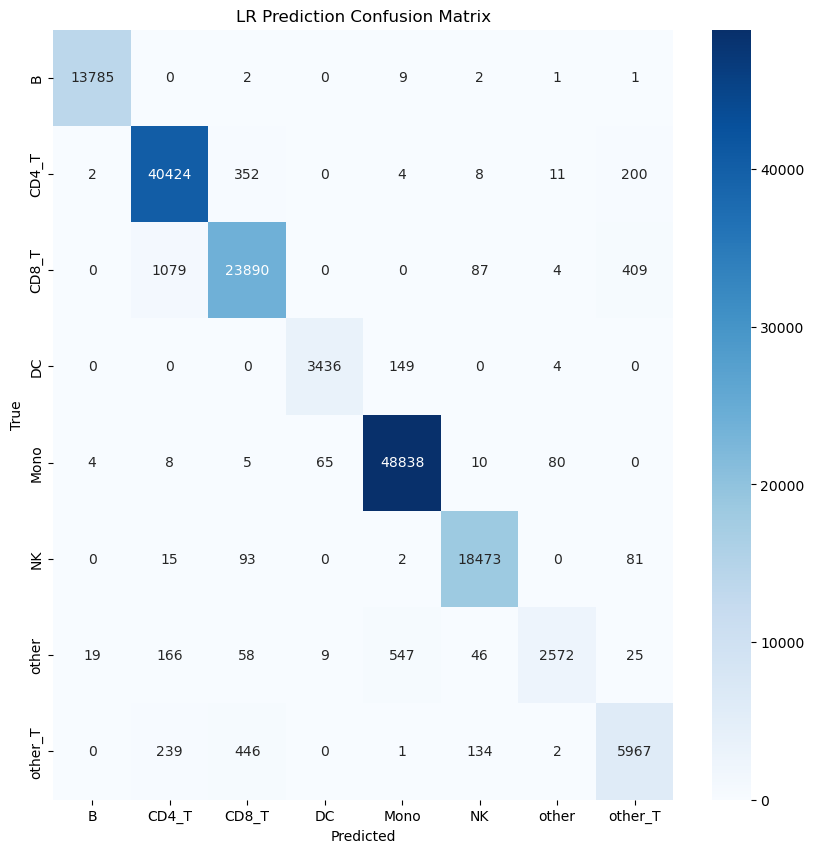

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [5]:
row_sum = cm.sum(axis=1)
row_sum


True
B          13800
CD4_T      41001
CD8_T      25469
DC          3589
Mono       49010
NK         18664
other       3442
other_T     6789
dtype: int64

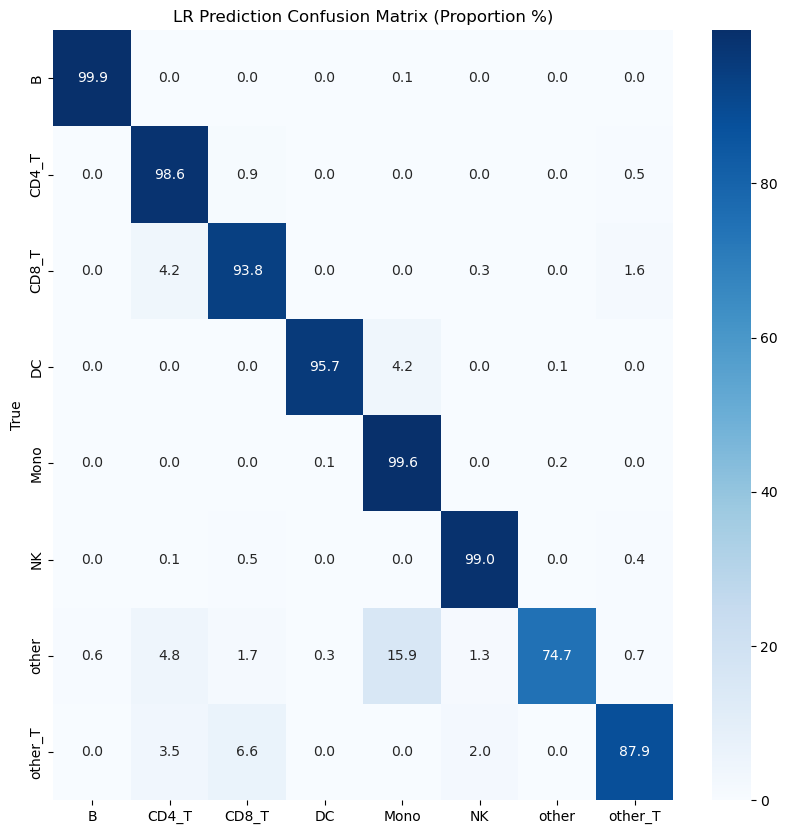

In [6]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 10))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.savefig('cm_plot.png', dpi=300)
plt.show()

## Calculate accuracy

In [7]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.972929700056873

In [8]:
cm.values.sum()

161764